In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from sympy import isprime


def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the distance between two points on the Earth's surface
    using the Haversine formula.
    """
    R = 6371.0  # Earth radius in kilometers

    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)

    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance



def create_distance_matrix(coordinates):
    """
    Create a distance matrix based on the coordinates of cities.
    """
    n = len(coordinates)
    distance_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            lat1, lon1 = coordinates[i]
            lat2, lon2 = coordinates[j]
            distance_matrix[i, j] = calculate_distance(lat1, lon1, lat2, lon2)

    return distance_matrix



def CalculateTourCost(tour, coordinates):
    cost = 0
    n = len(tour)
    distance_matrix = create_distance_matrix(coordinates)

    for i in range(n-1):
        city1 = tour[i]
        city2 = tour[i+1]
        cost += distance_matrix[city1, city2]

    # Add the distance from the last city back to the starting city
    cost += distance_matrix[tour[n-1], tour[0]]

    return cost



def RouletteWheelSelection(P):
    r = np.random.rand()
    C = np.cumsum(P)
    idx = np.where(r <= C)[0]
    return idx[0]



def TSPCrossover(parent1, parent2):
    nVar = len(parent1)
    child = np.zeros(nVar, dtype=int)

    # Select a random crossover point
    crossover_point = np.random.randint(1, nVar)

    # Create the child solution by combining parent genes
    child[:crossover_point] = parent1[:crossover_point]

    # Fill the remaining genes from parent2
    j = crossover_point
    for i in range(nVar):
        if parent2[i] not in child:
            child[j] = parent2[i]
            j += 1

    return child

def TSPMutation(solution):
    nVar = len(solution)

    # Select two random cities to swap
    idx1, idx2 = np.random.choice(nVar, size=2, replace=False)

    # Swap the cities
    solution[idx1], solution[idx2] = solution[idx2], solution[idx1]

    return solution


def DMOA_TSP(nPop, MaxIt, coordinates):
    # Number of cities
    nVar = len(coordinates)

    # Initialize variables
    nBabysitter = 3  # Number of babysitters
    nAlphaGroup = nPop - nBabysitter  # Number of Alpha group
    nScout = nAlphaGroup  # Number of Scouts
    L = round(0.6 * nVar * nBabysitter)  # Babysitter Exchange Parameter

    # Empty Mongoose Structure
    empty_mongoose = {'Tour': None, 'Cost': None}

    # Initialize Population Array
    pop = [empty_mongoose.copy() for _ in range(nAlphaGroup)]

    # Initialize Best Solution Ever Found
    BestSol = {'Tour': None, 'Cost': np.inf}

    # Create Initial Population
    for i in range(nAlphaGroup):
        pop[i]['Tour'] = np.random.permutation(nVar)
        pop[i]['Cost'] = CalculateTourCost(pop[i]['Tour'], coordinates)
        if pop[i]['Cost'] <= BestSol['Cost']:
            BestSol = pop[i].copy()

    # Abandonment Counter
    C = np.zeros(nAlphaGroup)

    # Array to Hold Best Cost Values
    BestCost = np.zeros(MaxIt)

    # DMOA Main Loop
    for it in range(MaxIt):
        # Alpha group
        F = np.zeros(nAlphaGroup)
        MeanCost = np.mean([mongoose['Cost'] for mongoose in pop])
        for i in range(nAlphaGroup):
            # Calculate Fitness Values and Selection of Alpha
            F[i] = np.exp(-pop[i]['Cost'] / MeanCost)  # Convert Cost to Fitness

        P = F / np.sum(F)
        # Foraging led by Alpha female
        for m in range(nAlphaGroup):
            # Select Alpha female
            i = RouletteWheelSelection(P)
            #print (f"{ pop[i]['Tour'] } :: {pop[i]['Cost']}")
            
            
            # Choose k randomly, not equal to Alpha
            K = [k for k in range(nAlphaGroup) if k != i]
            k = np.random.choice(K)

            # New Mongoose Tour
            newpop = empty_mongoose.copy()

            newpop['Tour'] = TSPCrossover(pop[i]['Tour'], pop[k]['Tour'])

            # Evaluation
            newpop['Cost'] = CalculateTourCost(newpop['Tour'], coordinates)

            # Comparison
            if newpop['Cost'] <= pop[i]['Cost']:
                pop[i] = newpop.copy()
            else:
                C[i] += 1

        # Scout group
        for i in range(nScout):
            # Choose k randomly, not equal to i
            K = [k for k in range(nAlphaGroup) if k != i]
            k = np.random.choice(K)


            # New Mongoose Tour
            newpop = empty_mongoose.copy()
            newpop['Tour'] = TSPMutation(pop[i]['Tour'])
            newpop['Cost'] = CalculateTourCost(newpop['Tour'], coordinates)
            
            
            # Comparison
            if newpop['Cost'] <= pop[i]['Cost']:
                pop[i] = newpop.copy()
            else:
                C[i] += 1

        # Babysitters
        for i in range(nBabysitter):
            if C[i] >= L:
                pop[i]['Tour'] = np.random.permutation(nVar)
                pop[i]['Cost'] = CalculateTourCost(pop[i]['Tour'], coordinates)
                C[i] = 0

        # Update Best Solution Ever Found
        for i in range(nAlphaGroup):
            if pop[i]['Cost'] <= BestSol['Cost']:
                BestSol = pop[i].copy()

        # Store Best Cost Ever Found
        BestCost[it] = BestSol['Cost']
        BEF = BestSol['Cost']
        BEP = BestSol['Tour']
        # Display Iteration Information
        print(f"Iteration {it + 1}: Best Cost = {BestCost[it]} :: Best Sol = {BEP}")
        
    
    
    # Show the final plot
    plt.plot(range(MaxIt), BestCost, 'b')
    plt.xlabel('Iteration')
    plt.ylabel('Best Cost')
    plt.title('Best Cost Progress')
    plt.grid(True)
    plt.show()
    
    return BEF, BEP, BestCost





# Example usage:
nPop = 80
MaxIt = 50


def plot_coordinates(coordinates, tour):
    latitudes = [lat for lat, _ in coordinates]
    longitudes = [lon for _, lon in coordinates]
    plt.scatter(longitudes, latitudes)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Node Coordinates')

    # Plot lines connecting the nodes
    n = len(coordinates)
    for i in range(n - 1):
        city1 = tour[i]
        city2 = tour[i + 1]
        plt.plot([longitudes[city1], longitudes[city2]], [latitudes[city1], latitudes[city2]], 'b')

    # Connect the last node with the first node
    city1 = tour[n - 1]
    city2 = tour[0]
    plt.plot([longitudes[city1], longitudes[city2]], [latitudes[city1], latitudes[city2]], 'b')

    plt.show()



# Read coordinates from CSV file
df = pd.read_csv("D:\shiref\Galala University\Semester 4\Design & Analysis of Algorithms (CSE 112)\projects\Dataset/traveling-santa-2018-prime-paths\cities1.csv")

# Extract X and Y columns from the DataFrame
x_values = df['X']
y_values = df['Y']

# Create a list of tuples for the coordinates
coordinates = list(zip(x_values, y_values))


BEF, BEP, BestCost = DMOA_TSP(nPop, MaxIt, coordinates)

"""
print("Best Solution:")
print("Cost:", BEF)
print("Tour:", BEP)
print("Best Cost History:", BestCost)
"""

Iteration 1: Best Cost = 151609.46452933497 :: Best Sol = [ 6 16 18  0 17 12  1 11  8  3 19  2  4 15 13 14  9  7 10  5]
Iteration 2: Best Cost = 148805.57183995936 :: Best Sol = [ 6 16 18 12 17  0  1 11  8  3 19  2 13  7  9 10  5 14 15  4]
Iteration 3: Best Cost = 148805.57183995936 :: Best Sol = [ 6 16 18 12 17  0  1 11 10  3 19  2 13  7  9  8  5 14 15  4]
Iteration 4: Best Cost = 148805.57183995936 :: Best Sol = [ 6 16 18 12 17  0  1 11 10  3  2 19 13  7  9  8  5 14 15  4]
Iteration 5: Best Cost = 148805.57183995936 :: Best Sol = [ 6 16 18 12 17  0  1 11 10  4  2 19 13  7  9  8  5 14 15  3]
Iteration 6: Best Cost = 145493.59860108644 :: Best Sol = [ 3  1 12  7  9 10  2 19  4 17  5 13  8 15 16 14 11 18  6  0]
Iteration 7: Best Cost = 141967.6618937807 :: Best Sol = [17  6 19  1 14  9 12  8 13  7 18  2 10  5  4 15 16 11  3  0]
Iteration 8: Best Cost = 141967.6618937807 :: Best Sol = [17  6 15  1 14  9 12  8 13  7 18  2 10  5  4 19 16 11  3  0]
Iteration 9: Best Cost = 141967.6618937807

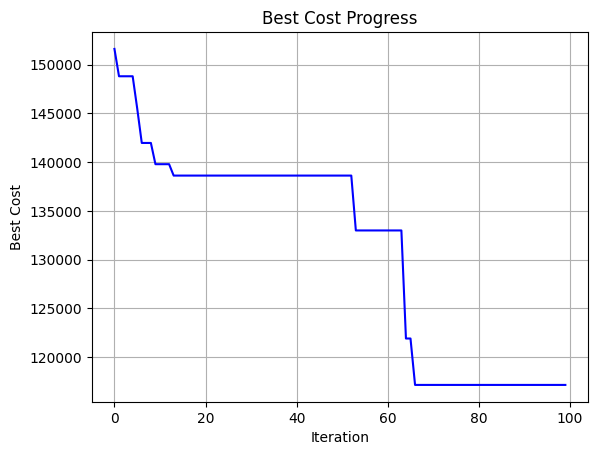

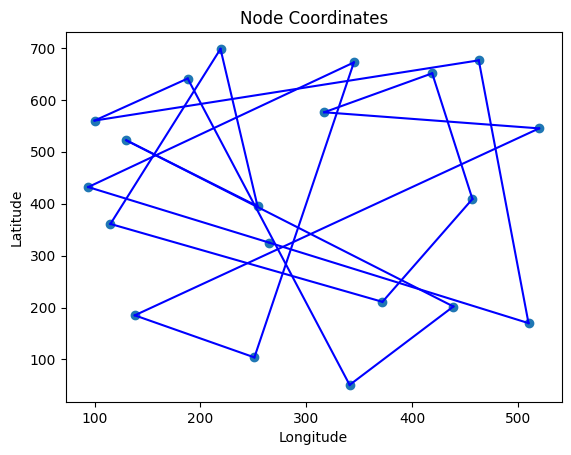

'\nprint("Best Solution:")\nprint("Cost:", BEF)\nprint("Tour:", BEP)\nprint("Best Cost History:", BestCost)\n'

In [10]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd


def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the distance between two points on the Earth's surface
    using the Haversine formula.
    """
    R = 6371.0  

    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)

    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance



def create_distance_matrix(coordinates):
    """
    Create a distance matrix based on the coordinates of cities.
    """
    n = len(coordinates)
    distance_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            lat1, lon1 = coordinates[i]
            lat2, lon2 = coordinates[j]
            distance_matrix[i, j] = calculate_distance(lat1, lon1, lat2, lon2)

    return distance_matrix



def CalculateTourCost(tour, coordinates):
    cost = 0
    n = len(tour)
    distance_matrix = create_distance_matrix(coordinates)

    for i in range(n-1):
        city1 = tour[i]
        city2 = tour[i+1]
        cost += distance_matrix[city1, city2]

    # Add the distance from the last city back to the starting city
    cost += distance_matrix[tour[n-1], tour[0]]

    return cost



def RouletteWheelSelection(P):
    r = np.random.rand()
    C = np.cumsum(P)
    idx = np.where(r <= C)[0]
    return idx[0]



def TSPCrossover(parent1, parent2):
    nVar = len(parent1)
    child = np.zeros(nVar, dtype=int)

    # Select a random crossover point
    crossover_point = np.random.randint(1, nVar)

    # Create the child solution by combining parent genes
    child[:crossover_point] = parent1[:crossover_point]

    # Fill the remaining genes from parent2
    j = crossover_point
    for i in range(nVar):
        if parent2[i] not in child:
            child[j] = parent2[i]
            j += 1
    
    return child

def TSPMutation(solution):
    nVar = len(solution)

    # Select two random cities to swap
    idx1, idx2 = np.random.choice(nVar, size=2, replace=False)

    # Swap the cities
    solution[idx1], solution[idx2] = solution[idx2], solution[idx1]

    return solution


def DMOA_TSP(nPop, MaxIt, coordinates):
    # Number of cities
    nVar = len(coordinates)

    # Initialize variables
    nBabysitter = 3  # Number of babysitters
    nAlphaGroup = nPop - nBabysitter  # Number of Alpha group
    nScout = nAlphaGroup  # Number of Scouts
    L = round(0.6 * nVar * nBabysitter)  # Babysitter Exchange Parameter

    # Empty Mongoose Structure
    empty_mongoose = {'Tour': None, 'Cost': None}

    # Initialize Population Array
    pop = [empty_mongoose.copy() for _ in range(nAlphaGroup)]

    # Initialize Best Solution Ever Found
    BestSol = {'Tour': None, 'Cost': np.inf}
    Iter = 1
 

    # Create Initial Population
    for i in range(nAlphaGroup):
        pop[i]['Tour'] = np.random.permutation(nVar)
        pop[i]['Cost'] = CalculateTourCost(pop[i]['Tour'], coordinates)
        if pop[i]['Cost'] <= BestSol['Cost']:
            BestSol = pop[i].copy()

    # Abandonment Counter
    C = np.zeros(nAlphaGroup)

    # Array to Hold Best Cost Values
    BestCost = np.zeros(MaxIt)

    # DMOA Main Loop
    for it in range(MaxIt):
        # Alpha group
        F = np.zeros(nAlphaGroup)
        MeanCost = np.mean([mongoose['Cost'] for mongoose in pop])
        for i in range(nAlphaGroup):
            # Calculate Fitness Values and Selection of Alpha
            F[i] = np.exp(-pop[i]['Cost'] / MeanCost)  # Convert Cost to Fitness

        P = F / np.sum(F)


        # Foraging led by Alpha female
        for m in range(nAlphaGroup):
            # Select Alpha female
            i = RouletteWheelSelection(P)
            #print (f"{ pop[i]['Tour'] } :: {pop[i]['Cost']}")
            
            
            # Choose k randomly, not equal to Alpha
            K = [k for k in range(nAlphaGroup) if k != i]
            k = np.random.choice(K)


            # New Mongoose Tour
            newpop = empty_mongoose.copy()

            newpop['Tour'] = TSPCrossover(pop[i]['Tour'], pop[k]['Tour'])

            # Evaluation
            newpop['Cost'] = CalculateTourCost(newpop['Tour'], coordinates)

            # Comparison
            if newpop['Cost'] <= pop[i]['Cost']:
                pop[i] = newpop.copy()
            else:
                C[i] += 1

        # Scout group
        for i in range(nScout):
           

            # New Mongoose Tour
            newpop = empty_mongoose.copy()
            newpop['Tour'] = TSPMutation(pop[i]['Tour'])
            newpop['Cost'] = CalculateTourCost(newpop['Tour'], coordinates)
            
            
            # Comparison
            if newpop['Cost'] <= pop[i]['Cost']:
                pop[i] = newpop.copy()
            else:
                C[i] += 1

        # Babysitters
        for i in range(nBabysitter):
            if C[i] >= L:
                pop[i]['Tour'] = np.random.permutation(nVar)
                pop[i]['Cost'] = CalculateTourCost(pop[i]['Tour'], coordinates)
                C[i] = 0

        # Update Best Solution Ever Found
        for i in range(nAlphaGroup):
            if pop[i]['Cost'] <= BestSol['Cost']:
                BestSol = pop[i].copy()



        # Store Best Cost Ever Found
        BestCost[it] = BestSol['Cost']
        BEF = BestSol['Cost']
        BEP = BestSol['Tour']
        # Display Iteration Information
        print(f"Iteration {it + 1}: Best Cost = {BestCost[it]} :: Best Sol = {BEP}")
        
        
        
    
    
    # Show the final plot
    plt.plot(range(MaxIt), BestCost, 'b')
    plt.xlabel('Iteration')
    plt.ylabel('Best Cost')
    plt.title('Best Cost Progress')
    plt.grid(True)
    plt.show()
    plot_coordinates(coordinates, BEP)
    
    return BEF, BEP, BestCost

# The rest of the code remains the same



# Example usage:
nPop = 50
MaxIt = 100


def read_tsp_file(file_path):
    coordinates = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith("NODE_COORD_SECTION"):
                break
        for line in file:
            line = line.strip()
            if line == "EOF":
                break
            data = line.split()
            coordinates.append((float(data[1]), float(data[2])))
    return coordinates


def plot_coordinates(coordinates, tour):
    latitudes = [lat for lat, _ in coordinates]
    longitudes = [lon for _, lon in coordinates]
    plt.scatter(longitudes, latitudes)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Node Coordinates')

    # Plot lines connecting the nodes
    n = len(coordinates)
    for i in range(n - 1):
        city1 = tour[i]
        city2 = tour[i + 1]
        plt.plot([longitudes[city1], longitudes[city2]], [latitudes[city1], latitudes[city2]], 'b')

    # Connect the last node with the first node
    city1 = tour[n - 1]
    city2 = tour[0]
    plt.plot([longitudes[city1], longitudes[city2]], [latitudes[city1], latitudes[city2]], 'b')

    plt.show()



file_path = "D:\shiref\Galala University\Semester 4\Design & Analysis of Algorithms (CSE 112)\projects\Dataset\sample.txt"  # Replace with the actual file path
coordinates = read_tsp_file(file_path)




BEF, BEP, BestCost = DMOA_TSP(nPop, MaxIt, coordinates)

"""
print("Best Solution:")
print("Cost:", BEF)
print("Tour:", BEP)
print("Best Cost History:", BestCost)
"""

In [6]:
# Create a DataFrame from the coordinates list
df = pd.DataFrame(BestCost)

# Save the DataFrame to a CSV file
df.to_csv('best.csv', index=False)

PermissionError: [Errno 13] Permission denied: 'best.csv'

In [11]:
print("Best Solution:")
print("Cost:", BEF)
print("Tour:", BEP)
print("Best Cost History:", BestCost)

Best Solution:
Cost: 117155.5109383592
Tour: [ 9  1  4 13 16 15 19 12 17  8 18  7 14 11  2  6  3 10  0  5]
Best Cost History: [151609.46452933 148805.57183996 148805.57183996 148805.57183996
 148805.57183996 145493.59860109 141967.66189378 141967.66189378
 141967.66189378 139790.35866703 139790.35866703 139790.35866703
 139790.35866703 138621.49848804 138621.49848804 138621.49848804
 138621.49848804 138621.49848804 138621.49848804 138621.49848804
 138621.49848804 138621.49848804 138621.49848804 138621.49848804
 138621.49848804 138621.49848804 138621.49848804 138621.49848804
 138621.49848804 138621.49848804 138621.49848804 138621.49848804
 138621.49848804 138621.49848804 138621.49848804 138621.49848804
 138621.49848804 138621.49848804 138621.49848804 138621.49848804
 138621.49848804 138621.49848804 138621.49848804 138621.49848804
 138621.49848804 138621.49848804 138621.49848804 138621.49848804
 138621.49848804 138621.49848804 138621.49848804 138621.49848804
 138621.49848804 132995.30370